<a href="https://colab.research.google.com/github/maticvl/dataHacker/blob/master/CNN/CNN_Neuro_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
def style_loss(base_style, gram_target):
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, filters = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    
    return tf.reduce_mean(tf.square(gram_style - gram_target)) #/ (4. * (filter ** 2) * (width * height) ** 2)

In [0]:
def compute_loss(model, alpha, beta, base_image, gram_style_features, content_features):
    
    # these are outputs of the pretrained VGG19 when we input our base image
    model_outputs = model(base_image)
    
    # extract the style and content features
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0
    
    # style losses from all layers
    
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += style_loss(comb_style[0], target_style)
        
    # content losses from all layers 
    
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score +=  content_loss(comb_content[0], target_content)
        
    style_score *= beta
    content_score *= alpha
    
    # Get total loss
    loss = style_score + content_score 
    
    return loss, style_score, content_score

In [0]:
def neuro_style_transfer(content_path,style_path,num_iterations=500,alpha=0.025,beta=1):
    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = VGG19(include_top=False, weights='imagenet')
    
    # Get output layers corresponding to style and content layers
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    # Build model 
    model =  models.Model(vgg.input, model_outputs)
    
    # Load our images
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    
    # computing content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
    # Get the style and content feature representations from our model
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    # Set initial image
    base_image = load_and_process_img(content_path)
    
    base_image = tfe.Variable(base_image, dtype=tf.float32)
    # Create our optimizer
    
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    # Store our best result
    best_loss, best_img = float('Inf'), None
    
    # For displaying
    num_rows = 2
    num_cols = 5
    
    display_interval = num_iterations/(num_rows*num_cols)
    
    imgs = []
    for i in range(num_iterations):
        
        with tf.GradientTape() as tape:
            
            all_loss = compute_loss(model, alpha, beta, base_image, gram_style_features, content_features)
        # Compute gradients wrt input image
        total_loss = all_loss[0]
        grads, all_loss =  tape.gradient(total_loss, base_image), all_loss
    
        loss, style_score, content_score = all_loss
    
        opt.apply_gradients([(grads, base_image)])
         
    
        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(base_image.numpy())

        if i % display_interval== 0:
            # Use the .numpy() method to get the concrete numpy array
            plot_img = base_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
        
    plt.figure(figsize=(25,10))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        
    return best_img, best_loss 

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block2_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1','block2_conv2','block3_conv2','block4_conv1','block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

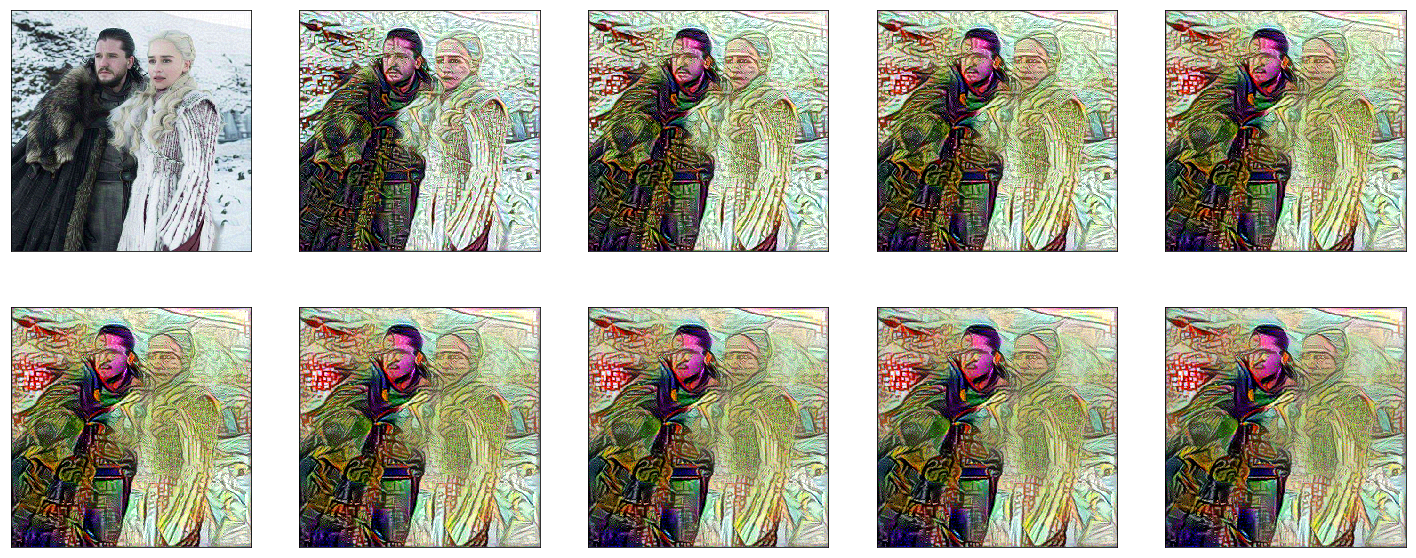

In [0]:
best_image, best_loss = neuro_style_transfer('got2.jpg','picasso2.jpg', num_iterations=500)

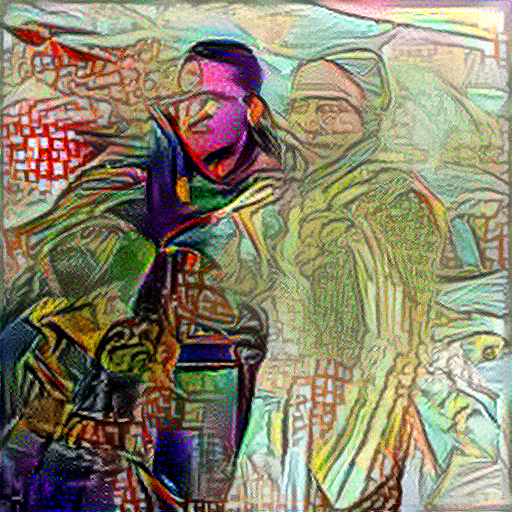

In [0]:
Image.fromarray(best_image)